In [2]:
import pandas as pd, warnings, numpy as np, seaborn as sns
from matplotlib import pyplot as plt, colormaps as cm
from matplotlib.gridspec import GridSpec as gs
from scipy.stats import pearsonr
import pickle as pk

### Assign protein features to candidate proteins evaluated by reporter assay

In [12]:
warnings.filterwarnings('ignore')
deg_stats = pd.read_excel("./Important_References/Deg_stats_final_pub.xlsx").drop(columns=['Unnamed: 0'])
ref = pd.read_excel('./Important_References/Flow_well_keys_pub.xlsx')
pro_features = pk.load(open('./Important_References/union_ortho_table_withFeatures.pk','rb'))


#Remove control strain rows from the deg_stats file
msm_filtered = deg_stats[deg_stats['Substrate']!='No Target'].copy()

# group strains by their deg constant
msm_filtered['Deg_group']=(msm_filtered['log2(Deg constant)'].values>-6)*1

# plate5 as validation set
msm_filtered['as_validation'] = [1 if x in ref[ref['Plate']=='Plate5']['Locus_tag'].unique() else 0 for x in msm_filtered['Locus']]

# import protein feature
numeric_feature_cols = list(pro_features.columns[25:])+['Msm_PI','Msm_Aliphatic_Index']
msm_filtered[numeric_feature_cols] = pro_features.loc[msm_filtered['Locus'].values,numeric_feature_cols].copy().values

### Save feature table

In [13]:
msm_filtered.to_csv('./Important_References/reporter_assay_features.csv')

### Interrogate relationship between steady state protein/RNA ratio vs. degradability

In [14]:
rna = pd.read_excel('./Important_References/20231107_Protein-RNA-corr.xlsx',
                    sheet_name='PMID_30957850_H37Rv_RPKM').set_index('Locus')
pro = pd.read_excel('./Important_References/20231107_Protein-RNA-corr.xlsx',
                    sheet_name='PMID_26094805_protein_abundance').set_index('Locus')
rna['mean_rpkm'] = rna[rna.columns[:2]].values.mean(axis=1)
overlap = [x for x in np.unique(np.concatenate([rna.index,pro.index])) if x in rna.index and x in pro.index ]
subset = pro.loc[overlap].copy()
subset['mean_rpkm'] = rna.loc[overlap]['mean_rpkm'].values
subset['log2(rpkm)'] = np.log2(subset['mean_rpkm'].values+1)
subset['Pro/RNA'] = subset['Protein'].values/subset['mean_rpkm'] 
subset['log2(Pro/RNA)'] = np.log2(subset['Pro/RNA'].values)

In [15]:
pro_rna_avalable = [x for x,v in msm_filtered[['Locus','Mtb_ortholog']].values if v in subset.index]
filtered_reindexed = msm_filtered.set_index('Locus').copy().loc[pro_rna_avalable].copy()
filtered_reindexed['log2(Pro/RNA)'] = subset.loc[list(filtered_reindexed['Mtb_ortholog'].values)]['log2(Pro/RNA)'].values

In [17]:
train_reindexed=filtered_reindexed[(filtered_reindexed['as_validation']==0)]

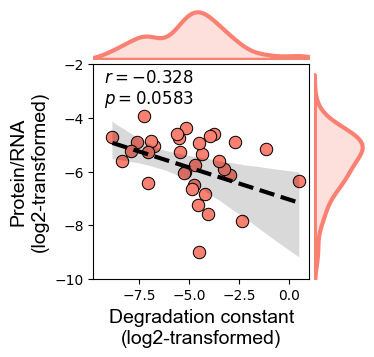

In [18]:
fig=plt.figure(figsize=(3.5,3.5))
grids = gs(5,5,hspace=0.1,wspace=0.1)
ax1 = fig.add_subplot(grids[0,:-1])
ax2 = fig.add_subplot(grids[1:,-1])
ax3 = fig.add_subplot(grids[1:,:-1])
sns.scatterplot(data=train_reindexed,
                x='log2(Deg constant)',
                y='log2(Pro/RNA)',ax=ax3,color='salmon',ec='black',s=80)
sns.regplot(data=train_reindexed,
                x='log2(Deg constant)',color='black',
                y='log2(Pro/RNA)',ax=ax3,scatter=False,line_kws={'lw':3,'ls':'--'})
sns.kdeplot(data=train_reindexed,x='log2(Deg constant)',ax=ax1,fill=True,
            color='salmon',bw_adjust=0.7,lw=3)
sns.kdeplot(data=train_reindexed,y='log2(Pro/RNA)',ax=ax2,fill=True,
            color='salmon',bw_adjust=0.7,lw=3)
ax3.set_ylim(-10,-2)
ax2.set_ylim(-10,-2)
ax3.set_xlim(-9.8,1)
ax1.set_xlim(-9.8,1)
ax1.axis('off')
ax2.axis('off')
ax3.set_xlabel('Degradation constant\n(log2-transformed)',fontsize=14,fontname='Arial')
ax3.set_ylabel('Protein/RNA\n(log2-transformed)',fontsize=14,fontname='Arial')
r,p = pearsonr(train_reindexed['log2(Deg constant)'],
               train_reindexed['log2(Pro/RNA)'])
ax3.text(0.05,0.82,'$r=$${}$\n$p=$${}$'.format(round(r,3),round(p,4)),transform=ax3.transAxes,fontsize=12,fontname='Arial',ha='left')
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20240120_protein-rna-ratio_deg_corr_trainset.svg',
            bbox_inches='tight')

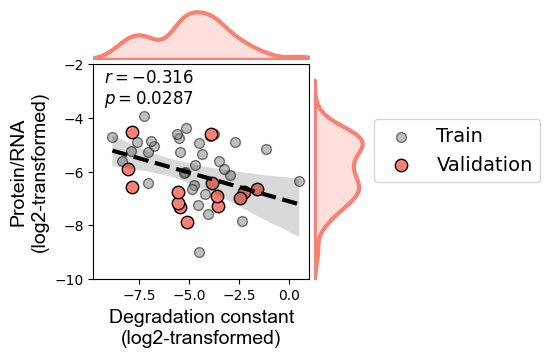

In [19]:
train_reindexed=filtered_reindexed[(filtered_reindexed['as_validation']==0)]
val_reindexed=filtered_reindexed[(filtered_reindexed['as_validation']==1)]
fig=plt.figure(figsize=(3.5,3.5))
grids = gs(5,5,hspace=0.1,wspace=0.1)
ax1 = fig.add_subplot(grids[0,:-1])
ax2 = fig.add_subplot(grids[1:,-1])
ax3 = fig.add_subplot(grids[1:,:-1])
ax3.scatter(data=train_reindexed,
                x='log2(Deg constant)',
                y='log2(Pro/RNA)',color='grey',ec='black',s=50,alpha=0.5,label='Train')
ax3.scatter(data=val_reindexed,
                x='log2(Deg constant)',
                y='log2(Pro/RNA)',color='salmon',ec='black',s=80,label='Validation')

sns.regplot(data=filtered_reindexed,
                x='log2(Deg constant)',color='black',
                y='log2(Pro/RNA)',ax=ax3,scatter=False,line_kws={'lw':3,'ls':'--'})
sns.kdeplot(data=filtered_reindexed,x='log2(Deg constant)',ax=ax1,fill=True,
            color='salmon',bw_adjust=0.7,lw=3)
sns.kdeplot(data=filtered_reindexed,y='log2(Pro/RNA)',ax=ax2,fill=True,
            color='salmon',bw_adjust=0.7,lw=3)
ax3.set_ylim(-10,-2)
ax2.set_ylim(-10,-2)
ax3.set_xlim(-9.8,1)
ax1.set_xlim(-9.8,1)
ax1.axis('off')
ax2.axis('off')
ax3.set_xlabel('Degradation constant\n(log2-transformed)',fontsize=14,fontname='Arial')
ax3.set_ylabel('Protein/RNA\n(log2-transformed)',fontsize=14,fontname='Arial')
r,p = pearsonr(filtered_reindexed['log2(Deg constant)'],
               filtered_reindexed['log2(Pro/RNA)'])
ax3.text(0.05,0.82,'$r=$${}$\n$p=$${}$'.format(round(r,3),round(p,4)),transform=ax3.transAxes,fontsize=12,fontname='Arial',ha='left')
ax3.legend(loc=(1.3,0.45),prop={'size':14})

plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20240120_protein-rna-ratio_deg_corr_fullset.svg',
            bbox_inches='tight')

In [21]:
cog=pd.read_excel('./Important_References/msm_cog_singleset.xls').set_index('locus')
func_annot = pd.read_excel('./Important_References/func_annot.xlsx').set_index('Functional_category')

In [22]:
manual_annot = {'MSMEG_3858':'K','MSMEG_3120':'M','MSMEG_3045':'M',
                'MSMEG_4943':'C','MSMEG_3144':'M','MSMEG_3072':'H',
                'MSMEG_4939':'C','MSMEG_4617':'H'}
filter_annot = {}
for x in msm_filtered['Locus'].values:
    if x in cog.index:
        if x not in manual_annot:
            filter_annot[x] = cog.loc[x]['Functional_category']
        else:
            filter_annot[x] = manual_annot[x]
    elif x in manual_annot:
        filter_annot[x] = manual_annot[x]
df = pd.DataFrame([[k,v] for k,v in filter_annot.items()],columns=['Locus','Functional_category'])        
df['Annotation'] = func_annot.loc[df['Functional_category'].values]['Annotation'].values
df['as_validation'] = msm_filtered.set_index('Locus').loc[df['Locus']]['as_validation'].values
df['Msm_PI'] = msm_filtered.set_index('Locus').loc[df['Locus']]['Msm_PI'].values
df['Msm_Aliphatic_Index'] = msm_filtered.set_index('Locus').loc[df['Locus']]['Msm_Aliphatic_Index'].values
df['total_residues'] = msm_filtered.set_index('Locus').loc[df['Locus']]['total_residues'].values
df['log2(Deg constant)'] = msm_filtered.set_index('Locus').loc[df['Locus']]['log2(Deg constant)'].values
df['Substrate'] = msm_filtered.set_index('Locus').loc[df['Locus']]['Substrate'].values

In [23]:
train_subset = df[df['as_validation']==0].copy()
val_subset = df[df['as_validation']==1].copy()

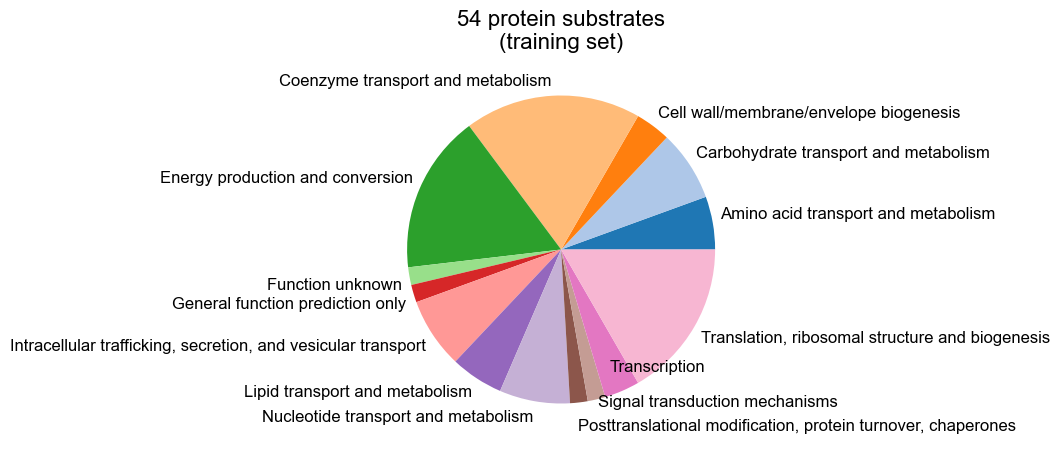

In [24]:
from adjustText import adjust_text as at 
grouped = train_subset.groupby('Annotation').count()
fig = plt.figure(figsize=(5,5))
colors = [cm.get_cmap('tab20')(i) for i in range(len(grouped))]
plt.pie(grouped['Functional_category'], rotatelabels=False,
        colors=colors,radius=1);
accum = 0
sum_v = grouped['Functional_category'].sum()
texts = []
for i,x in enumerate(grouped['Functional_category'].values):
    k = grouped.index[i]
    dx = 1.05*np.cos(2*np.pi*(accum + 0.5*x)/sum_v)
    dy = 1.05*np.sin(2*np.pi*(accum + 0.5*x)/sum_v)
    if dx<0:
        ha='right'
    else:
        ha='left'
    if dy<0:
        va='top'
    else:
        va='bottom'
    if k.startswith('Transcription'):
        dy+=0.25
        dx-=0.1
    if k.startswith('Signal'):
        dy+=0.08
    if k.startswith('Posttranslational'):
        dy-=0.05
        dx-=0.01
    texts.append(plt.text(dx,dy,k,ha=ha,va=va,fontname='Arial',
                         fontsize=12))
    
    accum += x
plt.title('54 protein substrates\n(training set)',fontname='Arial',fontsize=16)
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20240119_piechart_train.svg',transparent=True,
            bbox_inches='tight')

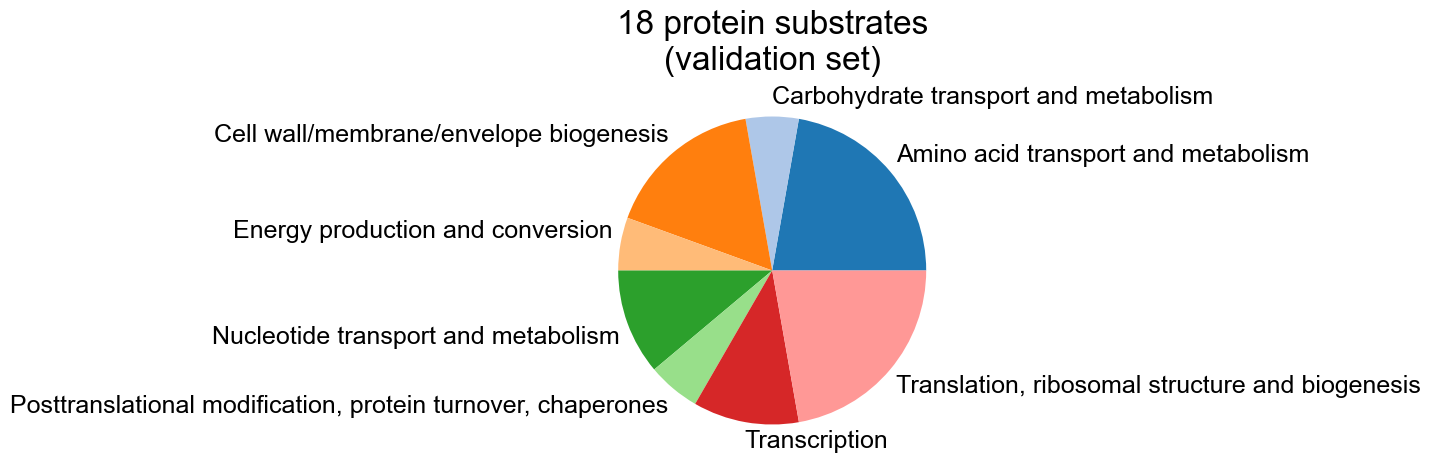

In [25]:
from adjustText import adjust_text as at 
grouped = val_subset.groupby('Annotation').count()
fig = plt.figure(figsize=(5,5))
colors = [cm.get_cmap('tab20')(i) for i in range(len(grouped))]
plt.pie(grouped['Functional_category'], rotatelabels=False,
        colors=colors,radius=1);
accum = 0
sum_v = grouped['Functional_category'].sum()
texts = []
for i,x in enumerate(grouped['Functional_category'].values):
    k = grouped.index[i]
    dx = 1.05*np.cos(2*np.pi*(accum + 0.5*x)/sum_v)
    dy = 1.05*np.sin(2*np.pi*(accum + 0.5*x)/sum_v)
    if dx<0:
        ha='right'
    else:
        ha='left'
    if dy<0:
        va='top'
    else:
        va='bottom'
    if k.startswith('Transcription'):

        ha='left'
    if k.startswith('Signal'):
        dy+=0.08
    texts.append(plt.text(dx,dy,k,ha=ha,va=va,fontname='Arial',
                         fontsize=18))
    
    accum += x
plt.title('18 protein substrates\n(validation set)',fontname='Arial',fontsize=24)
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20240119_piechart_val.svg',transparent=True,
            bbox_inches='tight')

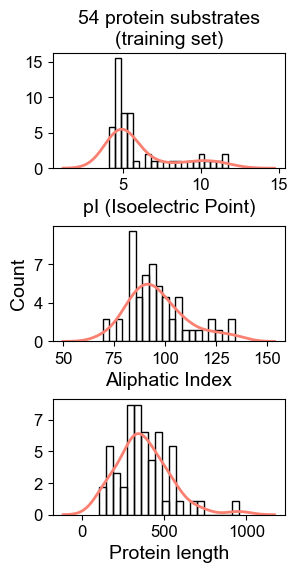

In [26]:
fig,axes=plt.subplots(figsize=(3,6),nrows=3,gridspec_kw={'hspace':0.5})
a1=axes[0].hist(train_subset['Msm_PI'].values,bins=20,
         density='True',fc='None',lw=1,ec='black')
sns.kdeplot(train_subset['Msm_PI'].values,
            color='salmon',lw=2,ax=axes[0])
a2=axes[1].hist(train_subset['Msm_Aliphatic_Index'].values,bins=20,
         density='True',fc='None',lw=1,ec='black')
sns.kdeplot(train_subset['Msm_Aliphatic_Index'].values,
            color='salmon',lw=2,ax=axes[1])
a3=axes[2].hist(train_subset['total_residues'].values,bins=20,
         density='True',fc='None',lw=1,ec='black')
sns.kdeplot(train_subset['total_residues'].values,
            color='salmon',lw=2,ax=axes[2])
axes[1].set_ylabel('')
axes[2].set_ylabel('')
hist_stats = [a1,a2,a3]
for i,ax in enumerate(axes):
    a = hist_stats[i]
    diff = np.diff(a[1])[0]
    ax.set_yticklabels([int(round(x*54*diff,0)) for x in ax.get_yticks()],
                       fontname='Arial',fontsize=12)
    ax.set_xticklabels([int(round(x,0)) for x in ax.get_xticks()],
                       fontname='Arial',fontsize=12)
axes[1].set_ylabel('Count',fontname='Arial',fontsize=14)
axes[0].set_ylabel('')
axes[0].set_xlabel('pI (Isoelectric Point)',fontname='Arial',fontsize=14)
axes[2].set_xlabel('Protein length',fontname='Arial',fontsize=14)
axes[1].set_xlabel('Aliphatic Index',fontname='Arial',fontsize=14)
axes[0].set_title('54 protein substrates\n(training set)',fontname='Arial',fontsize=14)
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20240119_basicFeature_trainset.svg',
            bbox_inches='tight',transparent=True)

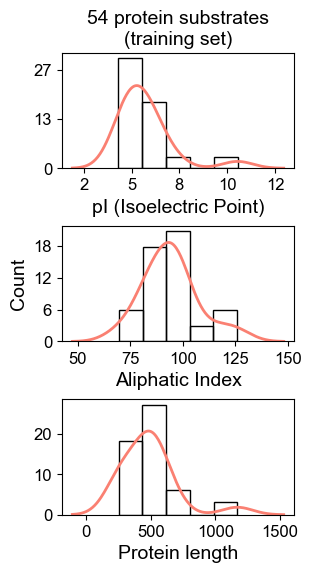

In [17]:
fig,axes=plt.subplots(figsize=(3,6),nrows=3,gridspec_kw={'hspace':0.5})
a1=axes[0].hist(val_subset['Msm_PI'].values,bins=5,
         density='True',fc='None',lw=1,ec='black')
sns.kdeplot(val_subset['Msm_PI'].values,
            color='salmon',lw=2,ax=axes[0])
a2=axes[1].hist(val_subset['Msm_Aliphatic_Index'].values,bins=5,
         density='True',fc='None',lw=1,ec='black')
sns.kdeplot(val_subset['Msm_Aliphatic_Index'].values,
            color='salmon',lw=2,ax=axes[1])
a3=axes[2].hist(val_subset['total_residues'].values,bins=5,
         density='True',fc='None',lw=1,ec='black')
sns.kdeplot(val_subset['total_residues'].values,
            color='salmon',lw=2,ax=axes[2])
axes[1].set_ylabel('')
axes[2].set_ylabel('')
hist_stats = [a1,a2,a3]
for i,ax in enumerate(axes):
    a = hist_stats[i]
    diff = np.diff(a[1])[0]
    ax.set_yticklabels([int(round(x*54*diff,0)) for x in ax.get_yticks()],
                       fontname='Arial',fontsize=12)
    ax.set_xticklabels([int(round(x,0)) for x in ax.get_xticks()],
                       fontname='Arial',fontsize=12)
axes[1].set_ylabel('Count',fontname='Arial',fontsize=14)
axes[0].set_ylabel('')
axes[0].set_xlabel('pI (Isoelectric Point)',fontname='Arial',fontsize=14)
axes[2].set_xlabel('Protein length',fontname='Arial',fontsize=14)
axes[1].set_xlabel('Aliphatic Index',fontname='Arial',fontsize=14)
axes[0].set_title('54 protein substrates\n(training set)',fontname='Arial',fontsize=14)
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20240119_basicFeature_valset.svg',
            bbox_inches='tight',transparent=True)

### import manually selected microscopy thumbnails

In [27]:
import glob
headers = []
png_dict = {}
for f in sorted(glob.glob('./Important_References/manually_selected_thumbnails/*.png')):
    # igore images from recombineering strains
    if 'REC' not in f:
        s,_rapa = f.split('/')[-1].split('_RAPA')
        r = _rapa[0]
        headers.append(s)
        if 'Well_' in s:
            s = s.split('_')[1]
        if s not in png_dict:
            png_dict[s]={r:f}
        else:
            png_dict[s][r]=f
unique_headers = np.unique(headers)

### compile thumbnails for the training set

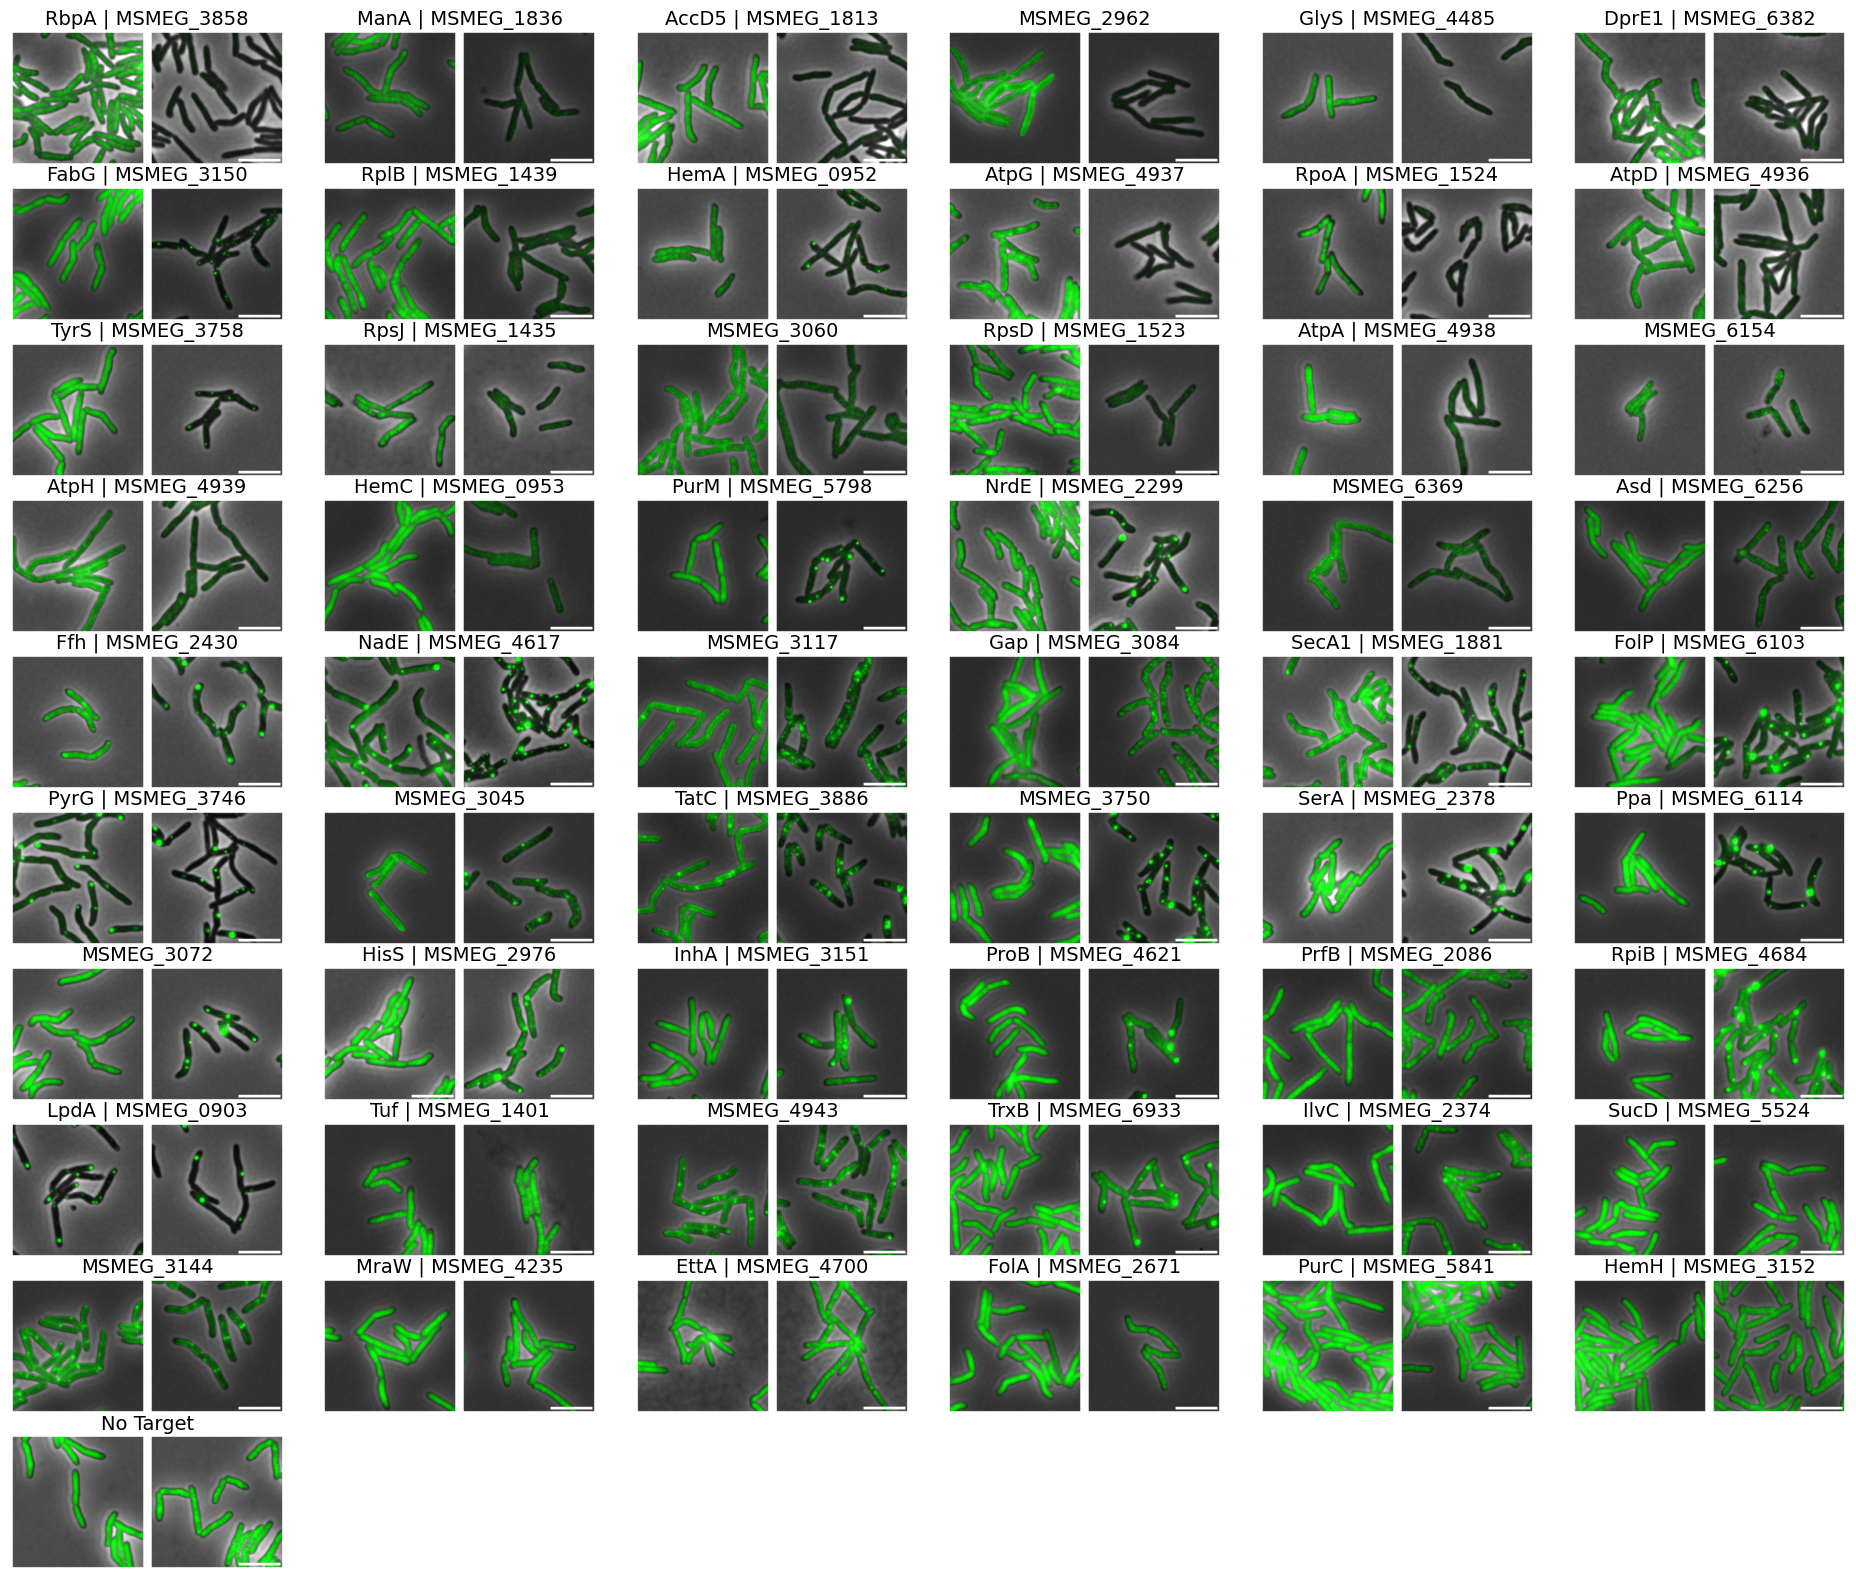

In [19]:
sorted_deg = train_subset.sort_values(by='log2(Deg constant)',ascending=False).copy()
fig=plt.figure(figsize=(24,20))
grids = gs(10,6,wspace=0.05,hspace=0.15)
for i,(s,l) in enumerate(sorted_deg[['Substrate','Locus']].values):
    if s != 'No Target':
        subset = ref[ref['Target_gene']==s]
        if len(subset) != 4:
            w = 'InhA'
        elif subset['Sample'].values[0].startswith('HW'):
            w = s
        else:
            _w = subset['Sample'].values[0]
            w = _w[0]+_w[1:].zfill(2)
    r,c = int(i/6),i%6
    ax = fig.add_subplot(grids[r,c])
    ax.set_xticks([])
    ax.set_yticks([])
    f1,f2 = png_dict[w]['-'],png_dict[w]['+']
    im1,im2 = plt.imread(f1),plt.imread(f2)
    ax.imshow(np.hstack([im1,im2])[10:-10,10:-10,:])
    ax.axis('off')
    if s==l or s=='No Target':
        ax.set_title(s,va = 'top',fontsize=14)
    else:
        ax.set_title('{} | {}'.format(s,l),va = 'top',fontsize=14)
ax = fig.add_subplot(grids[r+1,0])
ax.set_xticks([])
ax.set_yticks([])
f1,f2 = png_dict['HW84-2']['-'],png_dict['HW84-2']['+']
im1,im2 = plt.imread(f1),plt.imread(f2)
ax.imshow(np.hstack([im1,im2])[10:-10,10:-10,:])
ax.axis('off')
ax.set_title('No Target',va = 'top',fontsize=14)
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20240215_thumbnails_trainset.png',
            bbox_inches='tight',dpi=240,transparent=True)
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20240215_thumbnails_trainset.svg',
            bbox_inches='tight',transparent=True)

### compile thumbnails for the training set, omit strain names

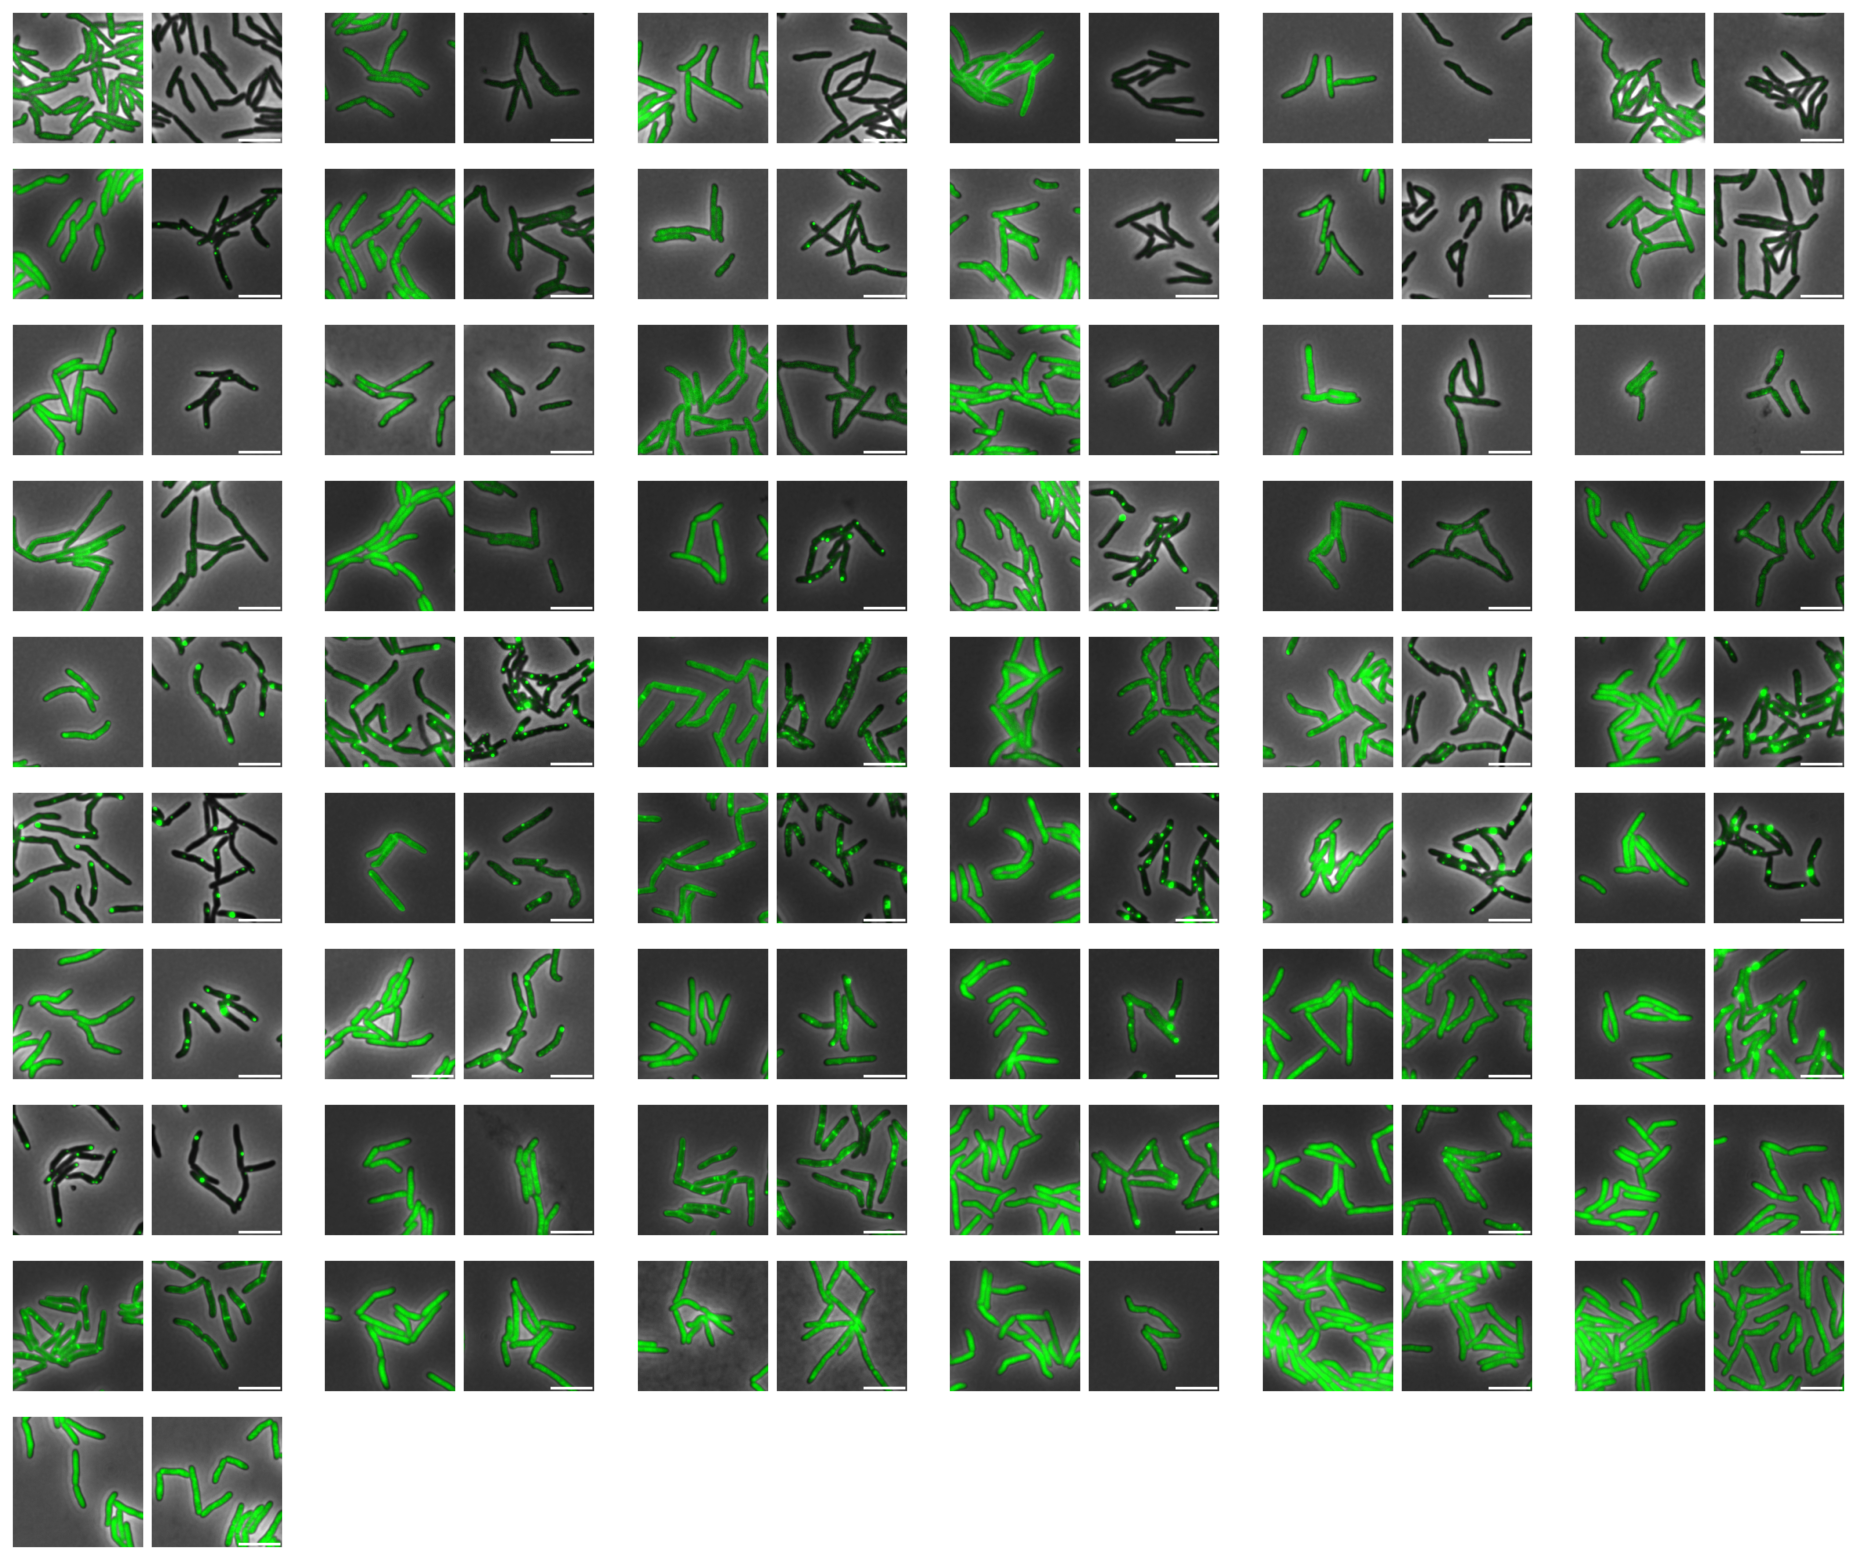

In [21]:
sorted_deg = train_subset.sort_values(by='log2(Deg constant)',ascending=False).copy()
fig=plt.figure(figsize=(24,20))
grids = gs(10,6,wspace=0.05,hspace=0.15)
for i,(s,l) in enumerate(sorted_deg[['Substrate','Locus']].values):
    if s != 'No Target':
        subset = ref[ref['Target_gene']==s]
        if len(subset) != 4:
            w = 'InhA'
        elif subset['Sample'].values[0].startswith('HW'):
            w = s
        else:
            _w = subset['Sample'].values[0]
            w = _w[0]+_w[1:].zfill(2)
    r,c = int(i/6),i%6
    ax = fig.add_subplot(grids[r,c])
    ax.set_xticks([])
    ax.set_yticks([])
    f1,f2 = png_dict[w]['-'],png_dict[w]['+']
    im1,im2 = plt.imread(f1),plt.imread(f2)
    ax.imshow(np.hstack([im1,im2])[10:-10,10:-10,:])
    ax.axis('off')
    #if s==l or s=='No Target':
    #    ax.set_title(s,va = 'top',fontsize=14)
    #else:
    #    ax.set_title('{} | {}'.format(s,l),va = 'top',fontsize=14)
ax = fig.add_subplot(grids[r+1,0])
ax.set_xticks([])
ax.set_yticks([])
f1,f2 = png_dict['HW84-2']['-'],png_dict['HW84-2']['+']
im1,im2 = plt.imread(f1),plt.imread(f2)
ax.imshow(np.hstack([im1,im2])[10:-10,10:-10,:])
ax.axis('off')
#ax.set_title('No Target',va = 'top',fontsize=14)
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20240215_thumbnails_trainset_noTitle.png',
            bbox_inches='tight',dpi=240,transparent=True)
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20240215_thumbnails_trainset_noTitle.svg',
            bbox_inches='tight',transparent=True)

### compile thumbnails for the validation set

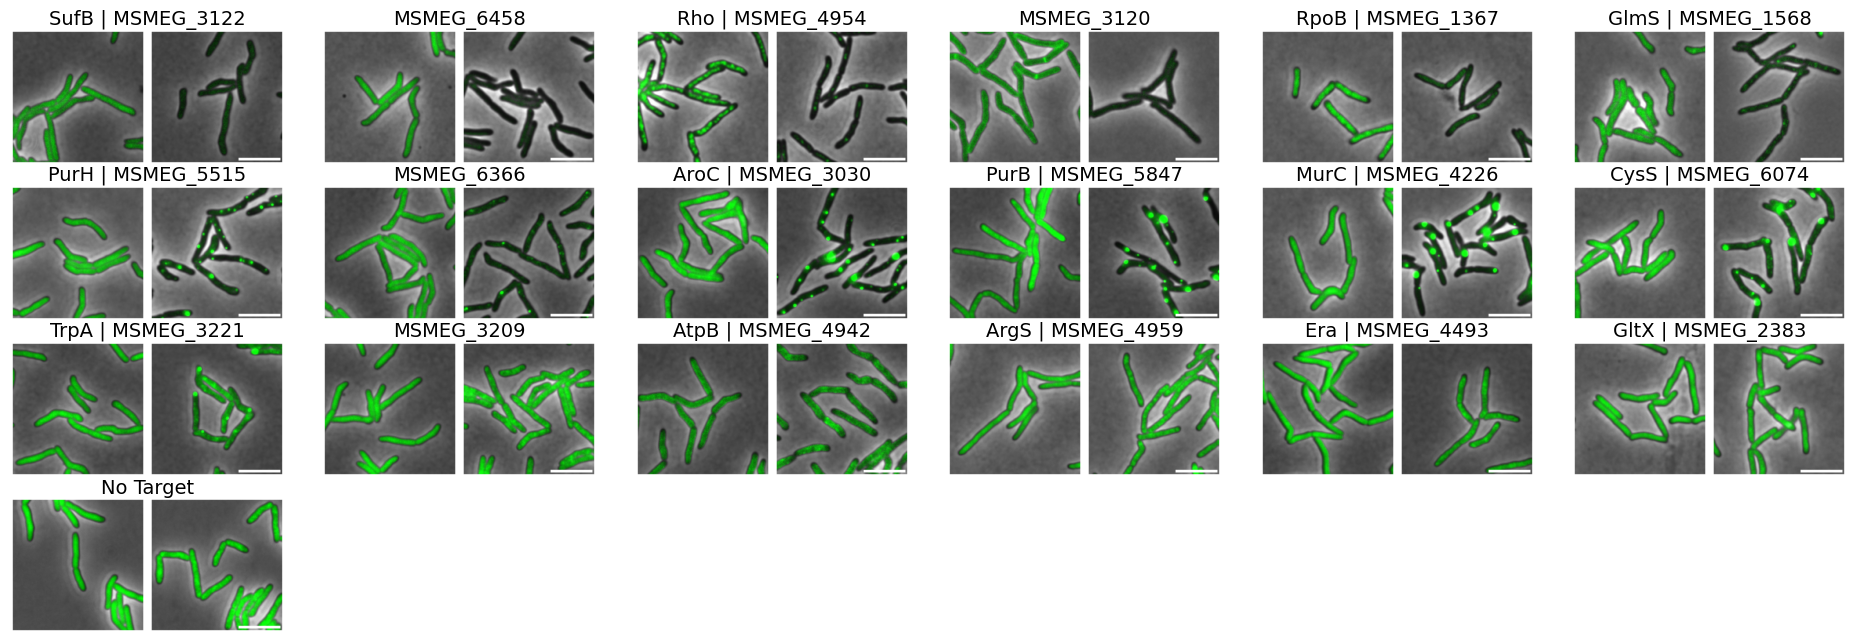

In [28]:
sorted_deg = val_subset.sort_values(by='log2(Deg constant)',ascending=False)
fig=plt.figure(figsize=(24,20))
grids = gs(10,6,wspace=0.05,hspace=0.15)
for i,(s,l) in enumerate(sorted_deg[['Substrate','Locus']].values):
    if s != 'No Target':
        subset = ref[ref['Target_gene']==s]
        if len(subset) != 4:
            w = 'InhA'
        elif subset['Sample'].values[0].startswith('HW'):
            w = s
        else:
            _w = subset['Sample'].values[0]
            w = _w[0]+_w[1:].zfill(2)
    r,c = int(i/6),i%6
    ax = fig.add_subplot(grids[r,c])
    ax.set_xticks([])
    ax.set_yticks([])
    f1,f2 = png_dict[w]['-'],png_dict[w]['+']
    im1,im2 = plt.imread(f1),plt.imread(f2)
    ax.imshow(np.hstack([im1,im2])[10:-10,10:-10,:])
    ax.axis('off')
    if s==l or s=='No Target':
        ax.set_title(s,va = 'top',fontsize=14)
    else:
        ax.set_title('{} | {}'.format(s,l),va = 'top',fontsize=14)
ax = fig.add_subplot(grids[r+1,0])
ax.set_xticks([])
ax.set_yticks([])
f1,f2 = png_dict['HW84-2']['-'],png_dict['HW84-2']['+']
im1,im2 = plt.imread(f1),plt.imread(f2)
ax.imshow(np.hstack([im1,im2])[10:-10,10:-10,:])
ax.axis('off')
ax.set_title('No Target',va = 'top',fontsize=14)
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20240215_thumbnails_val_set.png',
            bbox_inches='tight',dpi=240,transparent=True)
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20240215_thumbnails_val_set.svg',
            bbox_inches='tight',transparent=True)

### compile thumbnails for the validation set, omit strain names

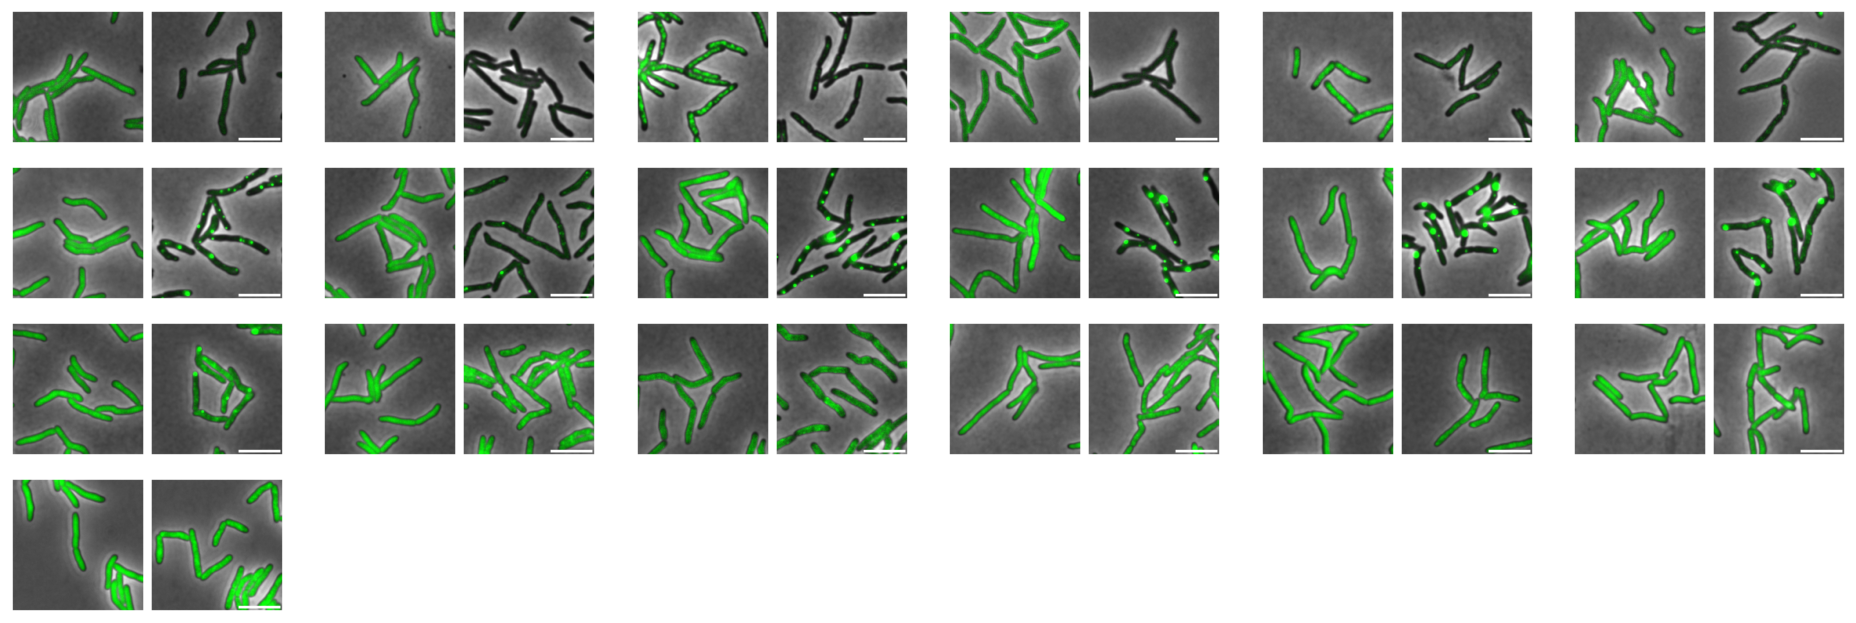

In [29]:
sorted_deg = val_subset.sort_values(by='log2(Deg constant)',ascending=False)
fig=plt.figure(figsize=(24,20))
grids = gs(10,6,wspace=0.05,hspace=0.15)
for i,(s,l) in enumerate(sorted_deg[['Substrate','Locus']].values):
    if s != 'No Target':
        subset = ref[ref['Target_gene']==s]
        if len(subset) != 4:
            w = 'InhA'
        elif subset['Sample'].values[0].startswith('HW'):
            w = s
        else:
            _w = subset['Sample'].values[0]
            w = _w[0]+_w[1:].zfill(2)
    r,c = int(i/6),i%6
    ax = fig.add_subplot(grids[r,c])
    ax.set_xticks([])
    ax.set_yticks([])
    f1,f2 = png_dict[w]['-'],png_dict[w]['+']
    im1,im2 = plt.imread(f1),plt.imread(f2)
    ax.imshow(np.hstack([im1,im2])[10:-10,10:-10,:])
    ax.axis('off')
    #if s==l or s=='No Target':
    #    ax.set_title(s,va = 'top',fontsize=14)
    #else:
    #    ax.set_title('{} | {}'.format(s,l),va = 'top',fontsize=14)
ax = fig.add_subplot(grids[r+1,0])
ax.set_xticks([])
ax.set_yticks([])
f1,f2 = png_dict['HW84-2']['-'],png_dict['HW84-2']['+']
im1,im2 = plt.imread(f1),plt.imread(f2)
ax.imshow(np.hstack([im1,im2])[10:-10,10:-10,:])
ax.axis('off')
#ax.set_title('No Target',va = 'top',fontsize=14)
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20240215_thumbnails_val_set_noTitle.png',
            bbox_inches='tight',dpi=240,transparent=True)
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20240215_thumbnails_val_set_noTitle.svg',
            bbox_inches='tight',transparent=True)

### render Fig. 3f

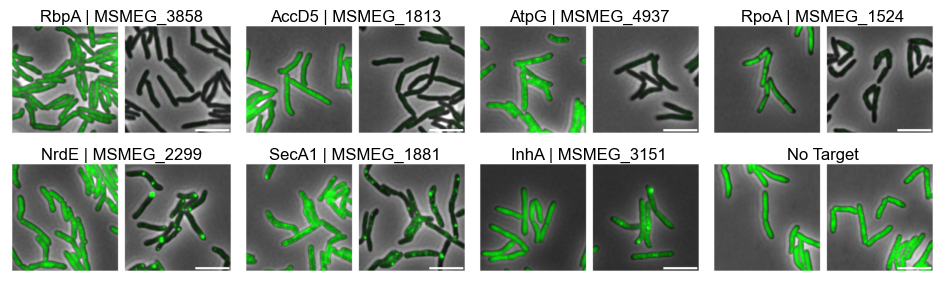

In [30]:
substrates = ['RbpA','AccD5','AtpG','RpoA','NrdE','SecA1','InhA']
fig=plt.figure(figsize=(24,3.5))
grids = gs(2,8,wspace=0.05,hspace=0.05)

for i,s in enumerate(substrates):
    subset = ref[ref['Target_gene']==s]
    if len(subset) != 4:
        w = 'InhA'
    elif subset['Sample'].values[0].startswith('HW'):
        w = s
    else:
        _w = subset['Sample'].values[0]
    l=subset['Locus_tag'].values[0]
    r,c = int(i/4),i%4
    ax = fig.add_subplot(grids[r,c])
    ax.set_xticks([])
    ax.set_yticks([])
    f1,f2 = png_dict[w]['-'],png_dict[w]['+']
    im1,im2 = plt.imread(f1),plt.imread(f2)
    ax.imshow(np.hstack([im1,im2])[10:-10,10:-10,:])
    ax.axis('off')
    if s==l or s=='No Target':
        ax.set_title(s,va = 'top',fontsize=12,fontname='Arial')
    else:
        ax.set_title('{} | {}'.format(s,l),va = 'top',fontsize=12,fontname='Arial')
ax = fig.add_subplot(grids[r,c+1])
ax.set_xticks([])
ax.set_yticks([])
f1,f2 = png_dict['HW84-2']['-'],png_dict['HW84-2']['+']
im1,im2 = plt.imread(f1),plt.imread(f2)
ax.imshow(np.hstack([im1,im2])[10:-10,10:-10,:])
ax.axis('off')
ax.set_title('No Target',va = 'top',fontsize=12,fontname='Arial')
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20240216_thumbnails_demo.png',
            bbox_inches='tight',dpi=240,transparent=True)
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20240216_thumbnails_demo.svg',
            bbox_inches='tight',transparent=True)

### render Fig. 3f, omit strain names

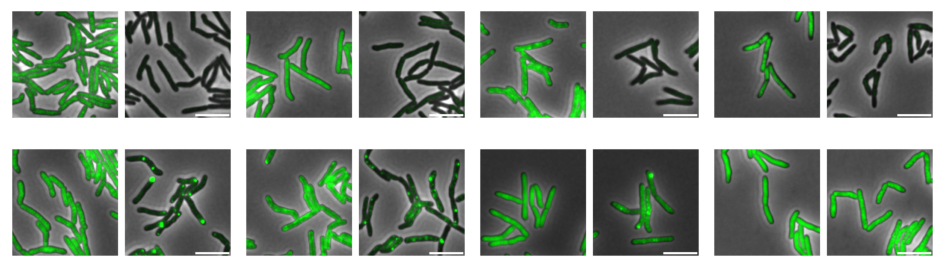

In [23]:
substrates = ['RbpA','AccD5','AtpG','RpoA','NrdE','SecA1','InhA']
fig=plt.figure(figsize=(24,3.5))
grids = gs(2,8,wspace=0.05,hspace=0.05)

for i,s in enumerate(substrates):
    subset = ref[ref['Target_gene']==s]
    if len(subset) != 4:
        w = 'InhA'
    elif subset['Sample'].values[0].startswith('HW'):
        w = s
    else:
        _w = subset['Sample'].values[0]
    l=subset['Locus_tag'].values[0]
    r,c = int(i/4),i%4
    ax = fig.add_subplot(grids[r,c])
    ax.set_xticks([])
    ax.set_yticks([])
    f1,f2 = png_dict[w]['-'],png_dict[w]['+']
    im1,im2 = plt.imread(f1),plt.imread(f2)
    ax.imshow(np.hstack([im1,im2])[10:-10,10:-10,:])
    ax.axis('off')
    #if s==l or s=='No Target':
    #    ax.set_title(s,va = 'top',fontsize=12,fontname='Arial')
    #else:
    #    ax.set_title('{} | {}'.format(s,l),va = 'top',fontsize=12,fontname='Arial')
ax = fig.add_subplot(grids[r,c+1])
ax.set_xticks([])
ax.set_yticks([])
f1,f2 = png_dict['HW84-2']['-'],png_dict['HW84-2']['+']
im1,im2 = plt.imread(f1),plt.imread(f2)
ax.imshow(np.hstack([im1,im2])[10:-10,10:-10,:])
ax.axis('off')
#ax.set_title('No Target',va = 'top',fontsize=12,fontname='Arial')
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20240216_thumbnails_demo_noTitle.png',
            bbox_inches='tight',dpi=240,transparent=True)
plt.savefig('/Users/jzrolling/Desktop/Projects/HSPH/BacPROTAC/Final_figures/20240216_thumbnails_demo_noTitle.svg',
            bbox_inches='tight',transparent=True)